# Binary Classification Sonar Project 1 for the Navy: 
# Mines vs. Rocks

## Step 1. Description of the Dataset

The dataset we will use in this tutorial is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different services. The 60 input variables are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders.

You can learn more about this dataset on the UCI Machine Learning repository:
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks) 

We have download the dataset for free and placed it in the project directory with the filename sonar.csv. You can also directly download the dataset:
https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data 

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

A benefit of using this dataset is that it is a standard benchmark problem. This means that we have some idea of the expected skill of a good model. Using cross-validation, a neural network should be able to achieve performance around 84% with an upper bound on accuracy for custom models at around 88%.

## Step 2. Baseline Neural Network Model Performance

Let’s create a baseline model and result for this project.

We will start off by importing all of the classes and functions we will need:


In [1]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Next, we can initialize the random number generator to ensure that we always get the same results when executing this code. This will help if we are debugging:

In [2]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Now we can load the dataset using pandas and split the columns into 60 input variables (X) and 1 output variable (Y). We use pandas to load the data because it easily handles strings (the output variable), whereas attempting to load the data directly using NumPy would be more difficult.


In [3]:
# load dataset
dataframe = pandas.read_csv("sonar.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]

The output variable is string values. We must convert them into integer values 0 and 1.

We can do this using the LabelEncoder class from scikit-learn. This class will model the encoding required using the entire dataset via the fit() function, then apply the encoding to create a new output variable using the transform() function.

We can use scikit-learn to evaluate the model using stratified k-fold cross validation. This is a resampling technique that will provide an estimate of the performance of the model. It does this by splitting the data into k-parts, training the model on all parts except one which is held out as a test set to evaluate the performance of the model. This process is repeated k-times and the average score across all constructed models is used as a robust estimate of performance. It is stratified, meaning that it will look at the output values and attempt to balance the number of instances that belong to each class in the k-splits of the data.

To use Keras models with scikit-learn, we must use the KerasClassifier wrapper. This class takes a function that creates and returns our neural network model. It also takes arguments that it will pass along to the call to fit() such as the number of epochs and the batch size.

Let’s start off by defining the function that creates our baseline model. Our model will have a single fully connected hidden layer with the same number of neurons as input variables. This is a good default starting point when creating neural networks.

The weights are initialized using a small Gaussian random number. The Rectifier activation function is used. The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1 that can easily and automatically be converted to crisp class values.

Finally, we are using the logarithmic loss function (binary_crossentropy) during training, the preferred loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics will be collected when the model is trained.

In [4]:
# encode labels
le = LabelEncoder()
encoded_Y = le.fit(Y).transform(Y)
# encoded_y

In [5]:
def baseline_model():
    
    model = Sequential()
    model.add(Dense(60, activation='relu', input_shape=(60,)))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

model_baseline=baseline_model()

import keras.utils
keras.utils.print_summary(model_baseline, line_length=None, positions=None, print_fn=None)

W0831 02:01:41.842031 140321972471616 deprecation_wrapper.py:119] From /home/muhammadfaizan/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 02:01:42.233720 140321972471616 deprecation_wrapper.py:119] From /home/muhammadfaizan/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 02:01:42.258549 140321972471616 deprecation_wrapper.py:119] From /home/muhammadfaizan/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 02:01:42.447505 140321972471616 deprecation_wrapper.py:119] From /home/muhammadfaizan/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/optimizers.py:790: The n

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 7,381
Trainable params: 7,381
Non-trainable params: 0
_________________________________________________________________


In [12]:
from keras.utils import plot_model
plot_model(model_baseline, to_file='baseline_model.png')

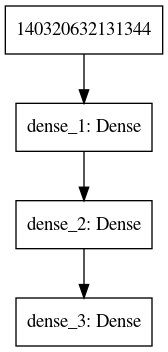

Now it is time to evaluate this model using stratified cross validation in the scikit-learn framework.

We pass the number of training epochs to the KerasClassifier, again using reasonable default values. Verbose output is also turned off given that the model will be created 10 times for the 10-fold cross validation being performed.

In [13]:
# evaluate baseline model
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print(f'Basline: Accuracy: {results.mean()*100} , Error: {results.std()*100}')

W0831 02:11:42.868532 140321972471616 deprecation_wrapper.py:119] From /home/muhammadfaizan/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Basline: Accuracy: 84.14310092745454 , Error: 6.775171468070057


## Step 3. Re-Run The Baseline Model With Data Preparation

It is a good practice to prepare your data before modeling.

Neural network models are especially suitable to having consistent input values, both in scale and distribution.

An effective data preparation scheme for tabular data when building neural network models is standardization. This is where the data is rescaled such that the mean value for each attribute is 0 and the standard deviation is 1. This preserves Gaussian and Gaussian-like distributions whilst normalizing the central tendencies for each attribute.

We can use scikit-learn to perform the standardization of our Sonar dataset using the StandardScaler class:
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html 

Rather than performing the standardization on the entire dataset, it is good practice to train the standardization procedure on the training data within the pass of a cross-validation run and to use the trained standardization to prepare the “unseen” test fold. This makes standardization a step in model preparation in the cross-validation process and it prevents the algorithm having knowledge of “unseen” data during evaluation, knowledge that might be passed from the data preparation scheme like a crisper distribution.
We can achieve this in scikit-learn using a Pipeline:
http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html 

The pipeline is a wrapper that executes one or more models within a pass of the cross-validation procedure. Here, we can define a pipeline with the StandardScaler followed by our neural network model.

In [19]:
# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print(f'Basline with standardized dataset: Accuracy: {results.mean()*100} , Error: {results.std()*100}')

Basline with standardized dataset: Accuracy: 85.08386745651677 , Error: 3.278007895555398


## Step 4. Tuning Layers and Number of Neurons in The Model

There are many things to tune on a neural network, such as the weight initialization, activation functions, optimization procedure and so on.

One aspect that may have an outsized effect is the structure of the network itself called the network topology. In this section, we take a look at two experiments on the structure of the network: making it smaller and making it larger.

These are good experiments to perform when tuning a neural network on your problem.

### 4.1. Evaluate a Smaller Network

We suspect that there is a lot of redundancy in the input variables for this project.

The data describes the same signal from different angles. Perhaps some of those angles are more relevant than others. We can force a type of feature extraction by the network by restricting the representational space in the first hidden layer.

In this experiment, we take our baseline model with 60 neurons in the hidden layer and reduce it by half to 30. This will put pressure on the network during training to pick out the most important structure in the input data to model.

We will also standardize the data as in the previous experiment with data preparation and try to take advantage of the small lift in performance.

Running this provides the following result. We can see that we have a very slight boost in the mean estimated accuracy and an important reduction in the standard deviation (average spread) of the accuracy scores for the model.

This is a great result because we are doing slightly better with a network half the size, which in turn takes half the time to train.

In [21]:
# smaller model
def create_smaller():
	# create model
    model = Sequential()
    model.add(Dense(30, activation='relu', input_shape=(60,)))
    model.add(Dense(1, activation='sigmoid'))
	# Compile model
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

smaller_model=create_smaller()
keras.utils.print_summary(smaller_model, line_length=None, positions=None, print_fn=None)
plot_model(smaller_model, to_file='smaller_model.png')

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Smaller: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 31        
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________
Smaller: 82.69% (4.72%)


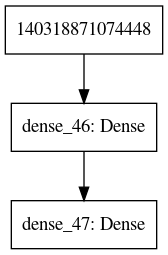

### Step 4.2. Evaluate a Larger Network

A neural network topology with more layers offers more opportunity for the network to extract key features and recombine them in useful nonlinear ways.

We can evaluate whether adding more layers to the network improves the performance easily by making another small tweak to the function used to create our model. Here, we add one new layer (one line) to the network that introduces another hidden layer with 30 neurons after the first hidden layer.

Our network now has the topology:

60 inputs -> [60 -> 30] -> 1 output

The idea here is that the network is given the opportunity to model all input variables before being bottlenecked and forced to halve the representational capacity, much like we did in the experiment above with the smaller network.

Instead of squeezing the representation of the inputs themselves, we have an additional hidden layer to aid in the process.

In [22]:
# larger model
def create_larger():
    # create model
    model = Sequential()
    model.add(Dense(60, activation='relu', input_shape=(60,)))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(30,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model, write code below
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

larger_model=create_larger()
keras.utils.print_summary(larger_model, line_length=None, positions=None, print_fn=None)
plot_model(larger_model, to_file='larger_model.png')

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_59 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_60 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 31        
Total params: 9,181
Trainable params: 9,181
Non-trainable params: 0
_________________________________________________________________
Larger: 83.66% (5.60%)


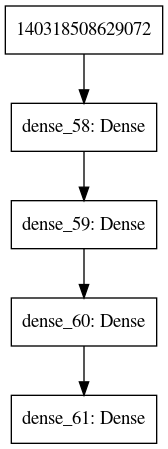

## Step 5: Really Scaling up: developing a model that overfits

Once you’ve obtained a model that has statistical power, the question becomes, is your
model sufficiently powerful? Does it have enough layers and parameters to properly
model the problem at hand? 

Remember that the universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.

To figure out how big a model you’ll need, you must develop a model that overfits.
This is fairly easy:
    1. Add layers.
    2. Make the layers bigger.
    3. Train for more epochs.

Always monitor the training loss and validation loss, as well as the training and validation values for any metrics you care about. When you see that the model’s performance on the validation data begins to degrade, you’ve achieved overfitting.

The next step is to start regularizing and tuning the model, to get as close as possible to the ideal model that neither underfits nor overfits.

## Step 6: Tuning the Model

With further tuning of aspects like the optimization algorithm etc. and the number of training epochs, it is expected that further improvements are possible. What is the best score that you can achieve on this dataset?

In [23]:
#taking the baseline model
def modified_baseline():
    
    model = Sequential()
    model.add(Dense(90, activation='relu', input_shape=(60,)))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(35, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

modified_baseline_model=modified_baseline()
keras.utils.print_summary(modified_baseline_model, line_length=None, positions=None, print_fn=None)
plot_model(modified_baseline_model, to_file='modified_baseline_model.png')

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=modified_baseline, epochs=500, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print(f'Modified Basline with standardized dataset: Accuracy: {results.mean()*100} , Error: {results.std()*100}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 90)                5490      
_________________________________________________________________
dense_83 (Dense)             (None, 60)                5460      
_________________________________________________________________
dense_84 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_85 (Dense)             (None, 35)                1085      
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 36        
Total params: 13,901
Trainable params: 13,901
Non-trainable params: 0
_________________________________________________________________
Modified Basline with standardized dataset: Accuracy: 84.60767715408663 , Error: 1.978220841926937


## Step 7: Rewriting the code using the Keras Functional API